In [1]:
# Code from https://towardsdatascience.com/implementing-alexnet-cnn-architecture-using-tensorflow-2-0-and-keras-2113e090ad98
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import time
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import shutil
from collections import Counter
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from keras.utils.layer_utils import count_params
from time import time

In [2]:
seed = 2802
test_size = 0.2
batch_size = 32

input_dir = "data/images"
target_dir = "data/mask"

input_shape = (320,320)

filters1 = [48, 64, 96]
filters2 = [128, 192,256]

step = 50
epochs = 250

In [3]:
df = pd.read_csv('data/dataset_train_test.csv') 
df['path'] = input_dir+'/'+df['image_name']+'.jpg'
df['category'] = np.where(df['class']==1, 0, np.where(df['class']==2, 0, 1)) #class_mode binary

df.head()

,Unnamed: 0,image_name,part,section,min_height,max_height,diff_height,piece_position,class,image_id,set,path,category
0,0,P01_001_0,P01,0,181,200,19,Down,2,1,Train,data/images/P01_001_0.jpg,0
1,1,P01_001_1,P01,1,198,208,10,Down,1,1,Train,data/images/P01_001_1.jpg,0
2,2,P01_001_2,P01,2,204,214,10,Down,1,1,Train,data/images/P01_001_2.jpg,0
3,3,P01_001_3,P01,3,200,212,12,Down,1,1,Train,data/images/P01_001_3.jpg,0
4,4,P01_002_0,P01,0,232,238,6,Down,1,2,Train,data/images/P01_002_0.jpg,0


In [4]:
datagen_normal = ImageDataGenerator(rescale=1./255)

train_generator_normal = datagen_normal.flow_from_dataframe(
    df[df['set']=='Train'],
    x_col='path', 
    y_col='category', 
    target_size=input_shape, 
    batch_size=batch_size,
    seed=seed,
    class_mode="raw",
    shuffle=True,)

validation_generator_normal = datagen_normal.flow_from_dataframe(
    df[df['set']=='Test'],
    x_col='path', 
    y_col='category', 
    target_size=input_shape, 
    batch_size=batch_size,
    class_mode="raw",
    seed=seed,
    shuffle=True,)

Found 856 validated image filenames.
Found 215 validated image filenames.


In [5]:
counts = np.bincount(train_generator_normal.labels)
total = counts[0]+counts[1]
weight_for_0 = (1 / counts[0]) * (total / 2.0)
weight_for_1 = (1 / counts[1]) * (total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}
class_weight

{0: 0.6455505279034691, 1: 2.2176165803108807}

In [6]:
def get_model(activation='relu', f1=48, f2=128, k1=17, k2=11, pool=7):
    model = keras.models.Sequential([
        keras.layers.Conv2D(filters=f1, kernel_size=(k1,k1), strides=(4,4), activation=activation, input_shape=(input_shape[0],input_shape[1],3), name='conv1'),
        keras.layers.BatchNormalization(name='batch1'),
        keras.layers.MaxPool2D(pool_size=(pool,pool), strides=(2,2), name='maxpool1'),
        keras.layers.Conv2D(filters=f2, kernel_size=(k2,k2), strides=(1,1), activation=activation, padding="same", name='conv2'),
        keras.layers.BatchNormalization(name='batch2'),
        keras.layers.GlobalAveragePooling2D(name='avg'),
        keras.layers.Dense(int(f2/2), activation=activation, name='dense1'),
        keras.layers.Dense(int(f2/4), activation=activation, name='dense2'),
        keras.layers.Dense(1, activation='sigmoid', name='denses')
    ])
    return model

In [7]:
optimizers = [
    {'opt': keras.optimizers.Adam(learning_rate=0.000001), 'name':'adam_0.000001'},    
]

losses= [ 
    {
    'name': 'normal',
    'loss': tf.keras.losses.BinaryCrossentropy(label_smoothing=0.15),
    'train' : train_generator_normal,
    'val': validation_generator_normal, 
    'cweights' : None
    }
]

{'name': 'normal', 'loss': <keras.losses.BinaryCrossentropy object at 0x000001A8874B0EC8>, 'train': <keras.preprocessing.image.DataFrameIterator object at 0x000001A8876CBE08>, 'val': <keras.preprocessing.image.DataFrameIterator object at 0x000001A848E0A348>, 'cweights': None}
small_alexnet_adam_0.000001_normal_f_48_128
INFO:tensorflow:Assets written to: results/small_alexnet_adam_0.000001_normal_f_48_128\assets


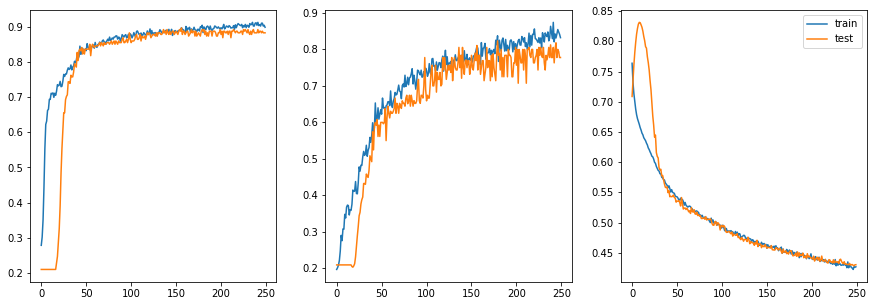

small_alexnet_adam_0.000001_normal_f_48_128





-------------------------------------------


,data,step,filter1,filter2,accuracy,val_accuracy,precision,val_precision
0,normal,50,48,128,0.837617,0.837209,0.635000,0.600000
1,normal,100,48,128,0.880841,0.865116,0.748634,0.690476
2,normal,150,48,128,0.890187,0.883721,0.770492,0.750000
3,normal,200,48,128,0.894860,0.893023,0.815951,0.805556
4,normal,250,48,128,0.899533,0.883721,0.832298,0.777778


,data,filter1,filter2,time,train_parameters,nontrain_parameters
0,normal,48,128,580.130267,795937,352


{'name': 'normal', 'loss': <keras.losses.BinaryCrossentropy object at 0x000001A8874B0EC8>, 'train': <keras.preprocessing.image.DataFrameIterator object at 0x000001A8876CBE08>, 'val': <keras.preprocessing.image.DataFrameIterator object at 0x000001A848E0A348>, 'cweights': None}
small_alexnet_adam_0.000001_normal_f_48_192
INFO:tensorflow:Assets written to: results/small_alexnet_adam_0.000001_normal_f_48_192\assets


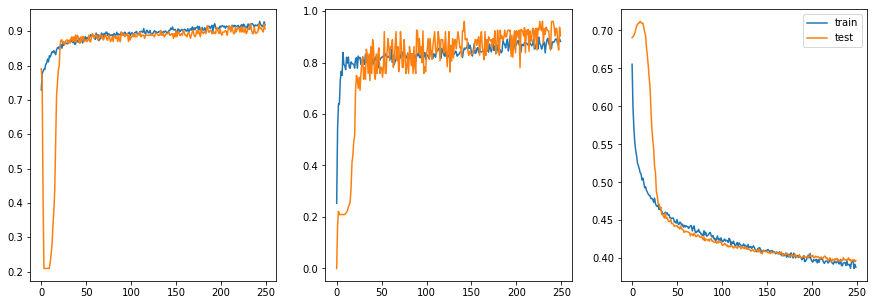

small_alexnet_adam_0.000001_normal_f_48_192





-------------------------------------------


,data,step,filter1,filter2,accuracy,val_accuracy,precision,val_precision
5,normal,50,48,192,0.884346,0.874419,0.817568,0.781250
6,normal,100,48,192,0.887850,0.874419,0.812903,0.764706
7,normal,150,48,192,0.905374,0.883721,0.858974,0.833333
8,normal,200,48,192,0.914720,0.906977,0.865854,0.837838
9,normal,250,48,192,0.918224,0.906977,0.881988,0.903226


,data,filter1,filter2,time,train_parameters,nontrain_parameters
0,normal,48,128,580.130267,795937,352
1,normal,48,192,569.929728,1180705,480


{'name': 'normal', 'loss': <keras.losses.BinaryCrossentropy object at 0x000001A8874B0EC8>, 'train': <keras.preprocessing.image.DataFrameIterator object at 0x000001A8876CBE08>, 'val': <keras.preprocessing.image.DataFrameIterator object at 0x000001A848E0A348>, 'cweights': None}
small_alexnet_adam_0.000001_normal_f_48_256
INFO:tensorflow:Assets written to: results/small_alexnet_adam_0.000001_normal_f_48_256\assets


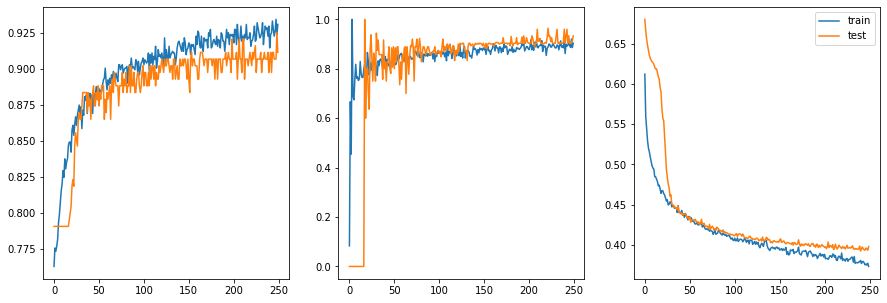

small_alexnet_adam_0.000001_normal_f_48_256





-------------------------------------------


,data,step,filter1,filter2,accuracy,val_accuracy,precision,val_precision
10,normal,50,48,256,0.878505,0.888372,0.829630,0.888889
11,normal,100,48,256,0.907710,0.902326,0.865385,0.875000
12,normal,150,48,256,0.914720,0.906977,0.884615,0.903226
13,normal,200,48,256,0.924065,0.906977,0.880952,0.903226
14,normal,250,48,256,0.931075,0.911628,0.903614,0.933333


,data,filter1,filter2,time,train_parameters,nontrain_parameters
0,normal,48,128,580.130267,795937,352
1,normal,48,192,569.929728,1180705,480
2,normal,48,256,561.559989,1570593,608


{'name': 'normal', 'loss': <keras.losses.BinaryCrossentropy object at 0x000001A8874B0EC8>, 'train': <keras.preprocessing.image.DataFrameIterator object at 0x000001A8876CBE08>, 'val': <keras.preprocessing.image.DataFrameIterator object at 0x000001A848E0A348>, 'cweights': None}
small_alexnet_adam_0.000001_normal_f_64_128
INFO:tensorflow:Assets written to: results/small_alexnet_adam_0.000001_normal_f_64_128\assets


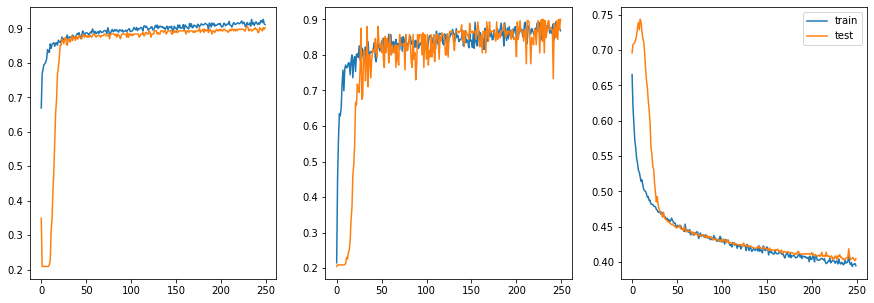

small_alexnet_adam_0.000001_normal_f_64_128





-------------------------------------------


,data,step,filter1,filter2,accuracy,val_accuracy,precision,val_precision
15,normal,50,64,128,0.885514,0.879070,0.823129,0.827586
16,normal,100,64,128,0.891355,0.883721,0.816456,0.833333
17,normal,150,64,128,0.901869,0.893023,0.838509,0.866667
18,normal,200,64,128,0.914720,0.893023,0.879747,0.843750
19,normal,250,64,128,0.911215,0.902326,0.867925,0.900000


,data,filter1,filter2,time,train_parameters,nontrain_parameters
0,normal,48,128,580.130267,795937,352
1,normal,48,192,569.929728,1180705,480
2,normal,48,256,561.559989,1570593,608
3,normal,64,128,519.873722,1057665,384


{'name': 'normal', 'loss': <keras.losses.BinaryCrossentropy object at 0x000001A8874B0EC8>, 'train': <keras.preprocessing.image.DataFrameIterator object at 0x000001A8876CBE08>, 'val': <keras.preprocessing.image.DataFrameIterator object at 0x000001A848E0A348>, 'cweights': None}
small_alexnet_adam_0.000001_normal_f_64_192
INFO:tensorflow:Assets written to: results/small_alexnet_adam_0.000001_normal_f_64_192\assets


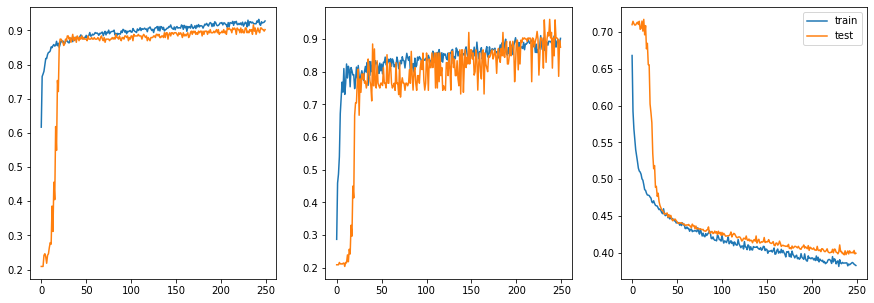

small_alexnet_adam_0.000001_normal_f_64_192





-------------------------------------------


,data,step,filter1,filter2,accuracy,val_accuracy,precision,val_precision
20,normal,50,64,192,0.878505,0.874419,0.802721,0.764706
21,normal,100,64,192,0.899533,0.874419,0.840764,0.764706
22,normal,150,64,192,0.901869,0.893023,0.842767,0.866667
23,normal,200,64,192,0.921729,0.893023,0.903846,0.823529
24,normal,250,64,192,0.927570,0.902326,0.901841,0.875000


,data,filter1,filter2,time,train_parameters,nontrain_parameters
0,normal,48,128,580.130267,795937,352
1,normal,48,192,569.929728,1180705,480
2,normal,48,256,561.559989,1570593,608
3,normal,64,128,519.873722,1057665,384
4,normal,64,192,526.127268,1566337,512


{'name': 'normal', 'loss': <keras.losses.BinaryCrossentropy object at 0x000001A8874B0EC8>, 'train': <keras.preprocessing.image.DataFrameIterator object at 0x000001A8876CBE08>, 'val': <keras.preprocessing.image.DataFrameIterator object at 0x000001A848E0A348>, 'cweights': None}
small_alexnet_adam_0.000001_normal_f_64_256
INFO:tensorflow:Assets written to: results/small_alexnet_adam_0.000001_normal_f_64_256\assets


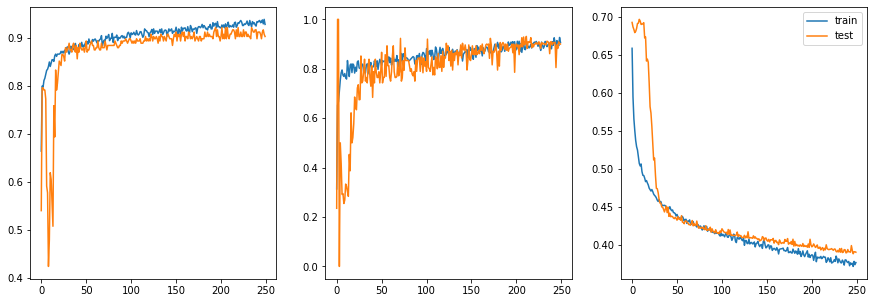

small_alexnet_adam_0.000001_normal_f_64_256





-------------------------------------------


,data,step,filter1,filter2,accuracy,val_accuracy,precision,val_precision
25,normal,50,64,256,0.889019,0.879070,0.826667,0.787879
26,normal,100,64,256,0.899533,0.897674,0.828221,0.828571
27,normal,150,64,256,0.913551,0.902326,0.874214,0.833333
28,normal,200,64,256,0.920561,0.893023,0.874251,0.892857
29,normal,250,64,256,0.927570,0.902326,0.906832,0.900000


,data,filter1,filter2,time,train_parameters,nontrain_parameters
1,normal,48,192,569.929728,1180705,480
2,normal,48,256,561.559989,1570593,608
3,normal,64,128,519.873722,1057665,384
4,normal,64,192,526.127268,1566337,512
5,normal,64,256,538.994335,2080129,640


{'name': 'normal', 'loss': <keras.losses.BinaryCrossentropy object at 0x000001A8874B0EC8>, 'train': <keras.preprocessing.image.DataFrameIterator object at 0x000001A8876CBE08>, 'val': <keras.preprocessing.image.DataFrameIterator object at 0x000001A848E0A348>, 'cweights': None}
small_alexnet_adam_0.000001_normal_f_96_128
INFO:tensorflow:Assets written to: results/small_alexnet_adam_0.000001_normal_f_96_128\assets


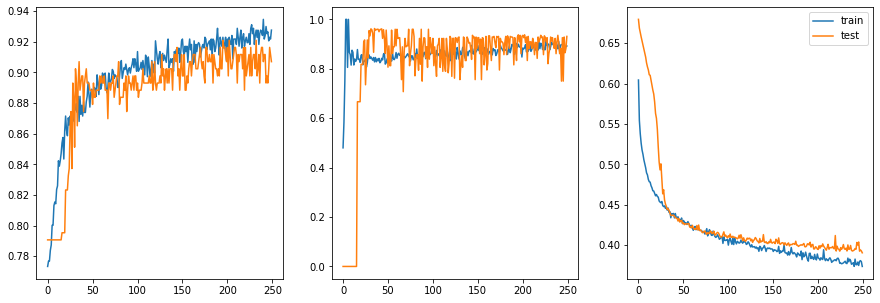

small_alexnet_adam_0.000001_normal_f_96_128





-------------------------------------------


,data,step,filter1,filter2,accuracy,val_accuracy,precision,val_precision
30,normal,50,96,128,0.889019,0.888372,0.840278,0.888889
31,normal,100,96,128,0.900701,0.888372,0.880282,0.862069
32,normal,150,96,128,0.920561,0.911628,0.874251,0.882353
33,normal,200,96,128,0.907710,0.906977,0.847561,0.931035
34,normal,250,96,128,0.927570,0.906977,0.892216,0.931035


,data,filter1,filter2,time,train_parameters,nontrain_parameters
2,normal,48,256,561.559989,1570593,608
3,normal,64,128,519.873722,1057665,384
4,normal,64,192,526.127268,1566337,512
5,normal,64,256,538.994335,2080129,640
6,normal,96,128,543.278057,1581121,448


{'name': 'normal', 'loss': <keras.losses.BinaryCrossentropy object at 0x000001A8874B0EC8>, 'train': <keras.preprocessing.image.DataFrameIterator object at 0x000001A8876CBE08>, 'val': <keras.preprocessing.image.DataFrameIterator object at 0x000001A848E0A348>, 'cweights': None}
small_alexnet_adam_0.000001_normal_f_96_192
INFO:tensorflow:Assets written to: results/small_alexnet_adam_0.000001_normal_f_96_192\assets


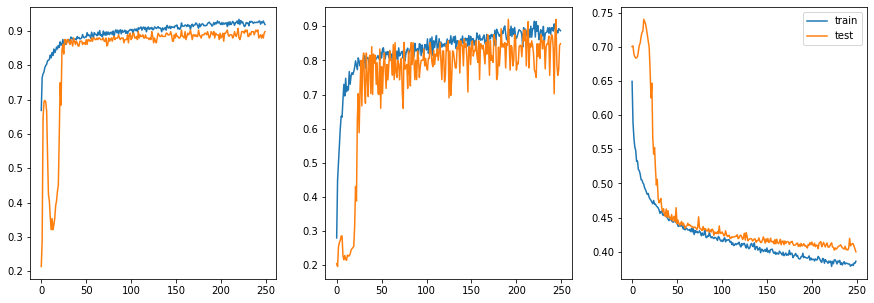

small_alexnet_adam_0.000001_normal_f_96_192





-------------------------------------------


,data,step,filter1,filter2,accuracy,val_accuracy,precision,val_precision
35,normal,50,96,192,0.882009,0.860465,0.823944,0.659574
36,normal,100,96,192,0.904206,0.893023,0.844720,0.805556
37,normal,150,96,192,0.914720,0.879070,0.870370,0.787879
38,normal,200,96,192,0.920561,0.893023,0.869823,0.866667
39,normal,250,96,192,0.918224,0.897674,0.886792,0.848485


,data,filter1,filter2,time,train_parameters,nontrain_parameters
3,normal,64,128,519.873722,1057665,384
4,normal,64,192,526.127268,1566337,512
5,normal,64,256,538.994335,2080129,640
6,normal,96,128,543.278057,1581121,448
7,normal,96,192,552.737021,2337601,576


{'name': 'normal', 'loss': <keras.losses.BinaryCrossentropy object at 0x000001A8874B0EC8>, 'train': <keras.preprocessing.image.DataFrameIterator object at 0x000001A8876CBE08>, 'val': <keras.preprocessing.image.DataFrameIterator object at 0x000001A848E0A348>, 'cweights': None}
small_alexnet_adam_0.000001_normal_f_96_256
INFO:tensorflow:Assets written to: results/small_alexnet_adam_0.000001_normal_f_96_256\assets


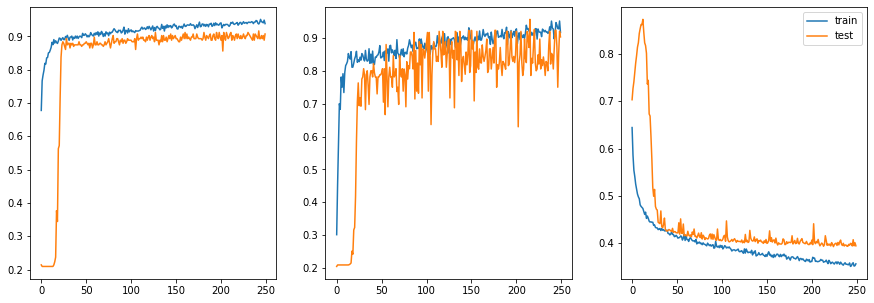

small_alexnet_adam_0.000001_normal_f_96_256





-------------------------------------------


,data,step,filter1,filter2,accuracy,val_accuracy,precision,val_precision
40,normal,50,96,256,0.907710,0.879070,0.839286,0.787879
41,normal,100,96,256,0.917056,0.888372,0.863095,0.862069
42,normal,150,96,256,0.931075,0.902326,0.898810,0.815789
43,normal,200,96,256,0.939252,0.897674,0.922156,0.848485
44,normal,250,96,256,0.938084,0.906977,0.916667,0.903226


,data,filter1,filter2,time,train_parameters,nontrain_parameters
4,normal,64,192,526.127268,1566337,512
5,normal,64,256,538.994335,2080129,640
6,normal,96,128,543.278057,1581121,448
7,normal,96,192,552.737021,2337601,576
8,normal,96,256,575.009698,3099201,704


In [8]:
column_names = ['data', 'step', 'filter1', 'filter2','accuracy', 'val_accuracy', 'precision', 'val_precision']
data = pd.DataFrame(columns=column_names)

column_info = ['data', 'filter1', 'filter2', 'time', 'train_parameters', 'nontrain_parameters']
data_info = pd.DataFrame(columns=column_info)


for loss in losses:
    for optimizer in optimizers:
        for f1 in filters1:
            for f2 in filters2:
        
                print(loss)
                f_name = 'small_alexnet_'+optimizer['name']+'_'+loss['name']+'_f_'+str(f1)+'_'+str(f2)
                print(f_name)

                keras.backend.clear_session()
                model = get_model('relu',f1, f2)

                trainable_count = count_params(model.trainable_weights)
                non_trainable_count = count_params(model.non_trainable_weights)

                model.compile(loss = loss['loss'], optimizer = optimizer['opt'], metrics=["accuracy", keras.metrics.Precision(name='precision')])#, "categorical_accuracy"])
                start = time()
                h = model.fit(loss['train'],
                          epochs=epochs,
                          validation_data=loss['val'],
                          validation_freq=1,
                          class_weight=loss['cweights'],
                            verbose=False)
                train_time = time()-start

                df_historic = pd.DataFrame(h.history)
                df_historic.to_csv('results/'+f_name+'.csv')
                model.save('results/'+f_name)

                fig, ax = plt.subplots(1,3, figsize=(15, 5))

                ax[0].plot(df_historic['accuracy'].values, label='acc')
                ax[0].plot(df_historic['val_accuracy'].values, label='val_acc')
                ax[1].plot(df_historic['precision'].values)
                ax[1].plot(df_historic['val_precision'].values)
                ax[2].plot(df_historic['loss'].values, label='train')
                ax[2].plot(df_historic['val_loss'].values, label='test')
                plt.legend()

                plt.show()
                print(f_name)

                for i in range(5):
                    print()
                print('-------------------------------------------')


                for i in range(step,epochs+1,step):                            
                    results = [
                        loss['name'],
                        i,
                        f1,
                        f2,
                        df_historic['accuracy'].values[i-1], 
                        df_historic['val_accuracy'].values[i-1], 
                        df_historic['precision'].values[i-1],
                        df_historic['val_precision'].values[i-1],
                    ]

                    data = data.append(dict(zip(column_names,results)), ignore_index=True)
                display(data.tail())

                info = [loss['name'], f1,f2, train_time, trainable_count, non_trainable_count]
                data_info = data_info.append(dict(zip(column_info,info)), ignore_index=True)

                display(data_info.tail())

In [9]:
data.to_csv('results/results.csv', index=False)
data_info.to_csv('results/info.csv', index=False)

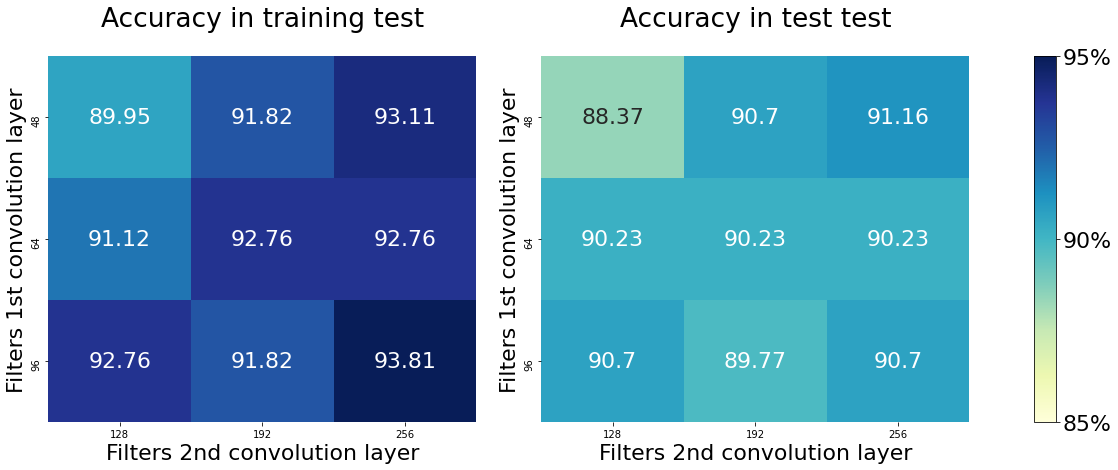

In [8]:
vmin= 85
vmax= 95

data = pd.read_csv('results/results.csv')
data_filter = data[(data['step']==epochs) & (data['data']=='normal')]
hmap = data_filter.pivot(index="filter1", columns="filter2", values="accuracy")
hmap_val = data_filter.pivot(index="filter1", columns="filter2", values="val_accuracy")

fig, axs = plt.subplots(ncols=3, gridspec_kw=dict(width_ratios=[4,4,0.2]), figsize=(16,7))
plt.rcParams.update({'font.size': 22})

sns.heatmap(hmap*100, annot=True, cbar=False, ax=axs[0], vmin=vmin, cmap="YlGnBu", fmt=".4")
axs[0].set_ylabel('Filters 1st convolution layer', fontsize=22)
axs[0].set_xlabel('Filters 2nd convolution layer', fontsize=22)
axs[0].set_title('Accuracy in training test', pad=30)

ax2 = sns.heatmap(hmap_val*100, annot=True, cbar=False, ax=axs[1], vmin=vmin, vmax=vmax, cmap="YlGnBu", fmt=".4")
axs[1].set_ylabel('Filters 1st convolution layer', fontsize=22)
axs[1].set_xlabel('Filters 2nd convolution layer', fontsize=22)
axs[1].set_title('Accuracy in test test', pad=30)

cbar = fig.colorbar(axs[1].collections[0], cax=axs[2], ticks=[85,90,95])
cbar.ax.set_yticklabels(['85%','90%', '95%']) 
cbar.ax.tick_params(labelsize=22)

plt.tight_layout()
plt.savefig('results/img_matrix_accuracy.png', dpi=600)
plt.show()

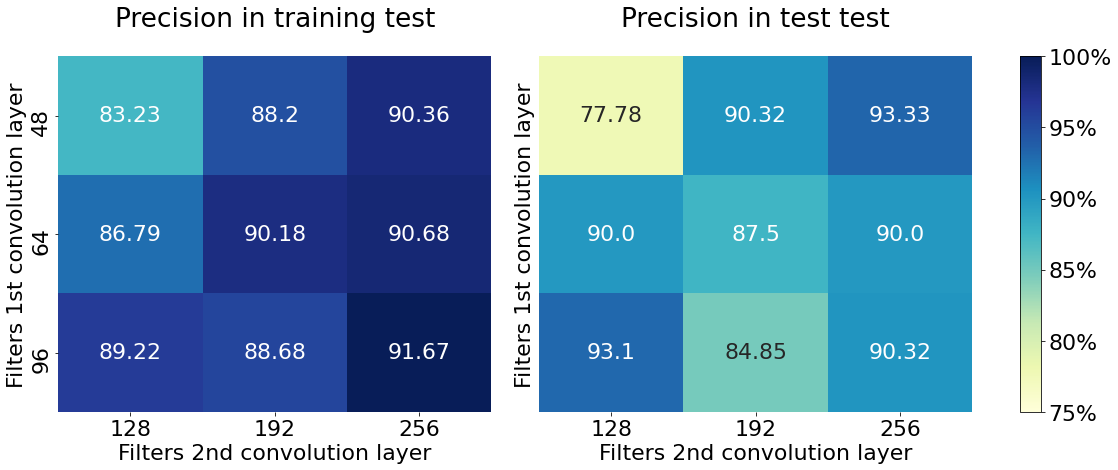

In [9]:
vmin= 75
vmax= 100

data = pd.read_csv('results/results.csv')
data_filter = data[(data['step']==epochs) & (data['data']=='normal')]
hmap = data_filter.pivot(index="filter1", columns="filter2", values="precision")
hmap_val = data_filter.pivot(index="filter1", columns="filter2", values="val_precision")

fig, axs = plt.subplots(ncols=3, gridspec_kw=dict(width_ratios=[4,4,0.2]), figsize=(16,7))
plt.rcParams.update({'font.size': 22})

sns.heatmap(hmap*100, annot=True, cbar=False, ax=axs[0], vmin=vmin, cmap="YlGnBu", fmt=".4")
axs[0].set_ylabel('Filters 1st convolution layer', fontsize=22)
axs[0].set_xlabel('Filters 2nd convolution layer', fontsize=22)
axs[0].set_title('Precision in training test', pad=30)

ax2 = sns.heatmap(hmap_val*100, annot=True, yticklabels=False, cbar=False, ax=axs[1], vmin=vmin, vmax=vmax, cmap="YlGnBu", fmt=".4")
axs[1].set_ylabel('Filters 1st convolution layer', fontsize=22)
axs[1].set_xlabel('Filters 2nd convolution layer', fontsize=22)
axs[1].set_title('Precision in test test', pad=30)

cbar = fig.colorbar(axs[1].collections[0], cax=axs[2], ticks=[75,80,85,90,95,100])
cbar.ax.set_yticklabels(['75%', '80%', '85%','90%', '95%','100%']) 

plt.tight_layout()
plt.savefig('results/img_matrix_precision.png', dpi=600)
plt.show()

In [10]:
data_info = pd.read_csv('results/info.csv')
data_info['eval_time'] =0.0

images = validation_generator_normal.next()
image = images[0][0,:,:,:]
img_tensor = np.expand_dims(image, axis=0)

In [13]:
for index, row in data_info.iterrows():
    folder = 'results/small_alexnet_adam_0.000001_normal_f_'+str(row.filter1)+'_'+str(row.filter2)    
    model = tf.keras.models.load_model(folder)
    
    start = time()
    model.predict(img_tensor)
    evaluation_time = (time()-start)*60
    data_info.at[index, 'eval_time'] = evaluation_time
    print(folder, evaluation_time)

1/1 [==============================] - 0s 200ms/step
results/small_alexnet_adam_0.000001_normal_f_48_128 16.294498443603516
1/1 [==============================] - 0s 186ms/step
results/small_alexnet_adam_0.000001_normal_f_48_192 15.676774978637695
1/1 [==============================] - 0s 193ms/step
results/small_alexnet_adam_0.000001_normal_f_48_256 16.131205558776855
1/1 [==============================] - 0s 190ms/step
results/small_alexnet_adam_0.000001_normal_f_64_128 16.55017375946045
1/1 [==============================] - 0s 190ms/step
results/small_alexnet_adam_0.000001_normal_f_64_192 18.29263687133789
1/1 [==============================] - 0s 200ms/step
results/small_alexnet_adam_0.000001_normal_f_64_256 17.313780784606934
1/1 [==============================] - 0s 191ms/step
results/small_alexnet_adam_0.000001_normal_f_96_128 20.78221321105957
1/1 [==============================] - 0s 195ms/step
results/small_alexnet_adam_0.000001_normal_f_96_192 21.83429718017578
1/1 [=======

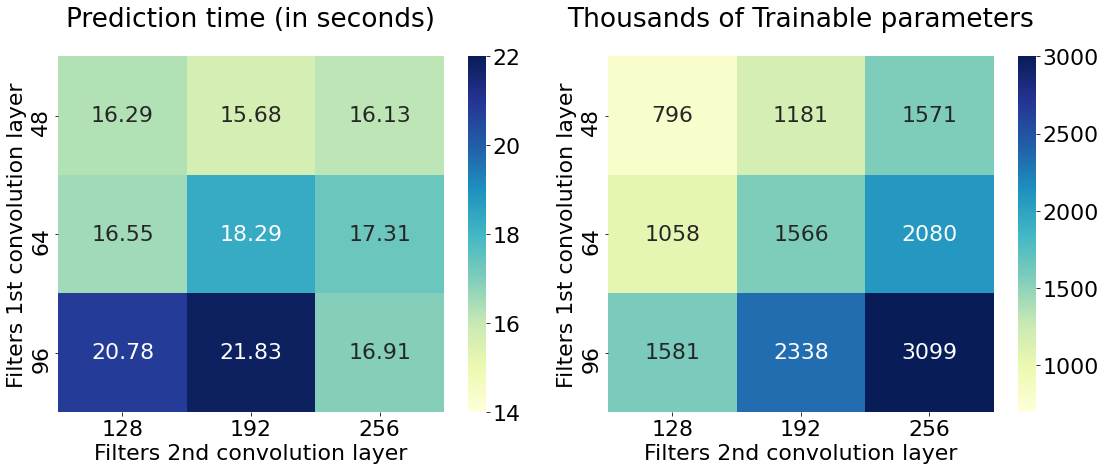

In [15]:
#data_info = pd.read_csv('results/info.csv')
hmap_time = data_info.pivot(index="filter1", columns="filter2", values="eval_time") #seconds
hmap_params = data_info.pivot(index="filter1", columns="filter2", values="train_parameters") #thousand of trainable parameters

fig, axs = plt.subplots(ncols=2, figsize=(16,7))
plt.rcParams.update({'font.size': 22})
sns.heatmap(hmap_time, annot=True, ax=axs[0], cmap="YlGnBu", fmt=".4", vmin=14, vmax= 22, cbar_kws={'ticks': [14,16,18,20,22]})
axs[0].set_ylabel('Filters 1st convolution layer', fontsize=22)
axs[0].set_xlabel('Filters 2nd convolution layer', fontsize=22)
axs[0].set_title('Prediction time (in seconds)', pad=30)


sns.heatmap(hmap_params/1000, annot=True, ax=axs[1], cmap="YlGnBu", fmt=".0f", vmin=700, vmax=3000)
axs[1].set_ylabel('Filters 1st convolution layer', fontsize=22)
axs[1].set_xlabel('Filters 2nd convolution layer', fontsize=22)
axs[1].set_title('Thousands of Trainable parameters', pad=30)

plt.tight_layout()
plt.savefig('results/img_matrix_train.png', dpi=600)

plt.show()